<h1 style="text-align: center; vertical-align: middle;">Numerical Methods in Accelerator Physics</h1>
<h2 style="text-align: center; vertical-align: middle;">Lecture Series by Dr. Adrian Oeftiger</h2>

<div style="width: 45%; margin: auto; margin-top: 1em; vertical-align: middle;">
<img src="./img/etit.png" style="width: 30%; float: left; margin-right: 5%;" /><img src="./img/GSI_Logo.png" style="width: 35%; float: left; margin-right: 5%; padding-top: 0.5em;" /><img src="./img/FAIR_Logo.png" style="width: 25%; float: left;" />
</div>

<h3 style="clear: both; text-align: center; margin-top: 1em;">Lecture 9</h3>

<h2>Run this notebook online!</h2>

Interact and run this jupyter notebook online:

<div class="alert alert-block alert-info" style="text-align:center;">
via the public mybinder.org service: <br />
<a href="https://mybinder.org/v2/gh/aoeftiger/TUDa-NMAP-2023/v11.1" style="width:auto; display:table;margin:0.5em auto;"><img src="./img/binder_logo.svg" alt="mybinder.org logo" height="1ex" /></a>
</div>

<div class="alert alert-block alert-info" style="text-align:center;">
via the public gesis.org service: <br />
<a href="https://notebooks.gesis.org/binder/v2/gh/aoeftiger/TUDA-NMAP-2023/v11.1" style="width:auto; display:table;margin:0.5em auto;"><img src="./img/binder_logo.svg" alt="gesis.org logo" height="1ex" /></a>
</div>

Also find this lecture rendered [as HTML slides on github $\nearrow$](https://aoeftiger.github.io/TUDa-NMAP-2023/) along with the [source repository $\nearrow$](https://github.com/aoeftiger/TUDa-NMAP-2023).

<h2>Run this first!</h2>

Imports and modules:

In [1]:
from config import (np, plt, radon, iradon, Image, 
                    tnrange, plot_mp, plot_tomo)
from scipy.constants import m_p, e, c
%matplotlib inline

If the progress bar by `tqdm` (`trange`) in this document does not work, run this:

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


<h2 style="color: #b51f2a">Refresher!</h2>

- Twiss parameters and phase advance from periodic transport matrix
- Betatron matrices and Twiss matrix: 2 representations of <b>identical</b> (stable/bounded) solution to Hill differential equation
- Stability of periodic transport matrices
- Optical / Twiss functions and Dispersion of a FODO cell
- Dipoles generate & quadrupoles focuse dispersion function
- Quadrupole focal length depends on momentum, tune change, chromaticity
- Chromatic tune change in a FODO cell
- Correction of chromaticity with sextupole magnets

<h2 style="color: #b51f2a">Today!</h2>

1. Intro to Tomographic Reconstruction
2. Phase-space Tomography

<div style="text-align: center; width:100%;">
    <h2>Part I: Intro to Tomographic Reconstruction</h2>
</div>

# Tomographic Reconstruction

<b>"Tomography"</b>: imaging via sectioning

<b>Origins</b>: mathematician J. Radon (AUT)
- 1917: "On the determination of functions from their integrals along certain manifolds"
- inverse problem
- <b>Fourier slice theorem</b>: any 2D (3D) object can be reconstructed from infinite set of 1D (2D) projections

<div style="float:right; width:15%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/UPMCEast_CTscan.jpg/800px-UPMCEast_CTscan.jpg" alt="CT scanner" style="width:100%;" />
<p style="font-size: small; text-align: right; margin-top:1em;">image from <a href="https://commons.wikimedia.org/wiki/File:UPMCEast_CTscan.jpg">daveynin, Wikimedia</a></p>
    <img src="https://upload.wikimedia.org/wikipedia/commons/6/68/3d_CT_scan_animation.gif" alt="Reconstructed CT scan" style="width:100%;" />
<p style="font-size: small; text-align: right; margin-top:1em;">image from <a href="https://commons.wikimedia.org/wiki/File:3d_CT_scan_animation.gif">Arielinson, Wikimedia</a></p>
    <img src="img/tomo.png" alt="Phase-space tomography at CERN PSB" style="width:100%;" />
<!--<a title="LucasVB, CC0, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Radon_transform_sinogram.gif"><img alt="Radon transform sinogram" src="https://upload.wikimedia.org/wikipedia/commons/9/93/Radon_transform_sinogram.gif" style="width:100%;" /></a>-->
</div>

# Many Applications

- medical: CT scan in hospitals (computed tomography)
    - 1979 Nobel price in Medicine: <br /> first CT scanner by Sir G.N. Hounsfield
- material science
- airport security
- accelerator physics
- ...

# Projection Integral or Radon Transform $\mathcal{R}_\theta(p)$

$$\require{color}
\mathcal{R}_\theta(p)\, f = \int dx\int dy~ f(x, y) \,\underbrace{\delta(x\,\cos \theta+y\,\sin\theta-p)}\limits_{\color{red}\text{projection slice}}$$

<img src="img/radon.png" alt="Radon transform" style="width:30%;margin:auto;" />

<p style="font-size: small; text-align: right;">image from <a href="https://twitter.com/docmilanfar/status/1366229985975930881/photo/1">@docmilanfar, Twitter</a></p>

Load sample image for the tomography:

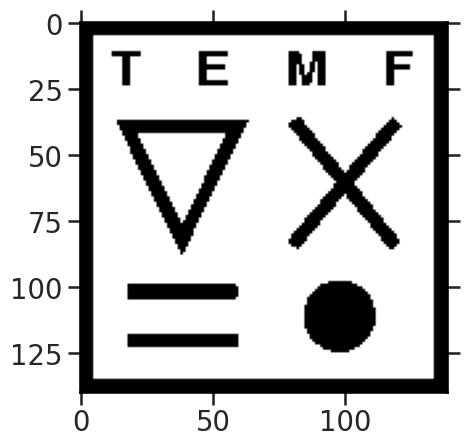

In [3]:
data = ~np.array(Image.open('src/temf.png').convert('1', dither=False))

plt.imshow(data, cmap='binary');

Compute the Radon transform at an angle of 0 deg and 90 deg:

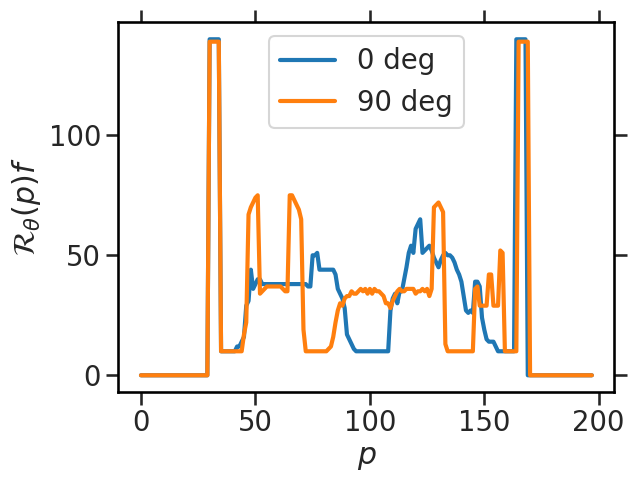

In [4]:
Rf_0 = radon(data, [0], circle=False).astype(float)
Rf_90 = radon(data, [90], circle=False).astype(float)

plt.plot(Rf_0, label='0 deg')
plt.plot(Rf_90, label='90 deg')
plt.legend()
plt.xlabel('$p$')
plt.ylabel(r'$\mathcal{R}_{\theta}(p)f$');

<h2>Preparing the Measurement Data</h2>

We take a number of `VIEW` measurements across the angular interval of [0,`ANG`] degrees:

In [5]:
# parameters
M = max(data.shape)
ANG = 180
VIEW = 180
THETA = np.linspace(0, ANG, VIEW, endpoint=False)

`A` is the projection operator, applying the Radon transform along all chosen angles `THETA` to the original object under study, $x$ (`data`):

In [6]:
A = lambda x: radon(x, THETA, circle=False).astype(float)

In [7]:
proj = A(data)

<h2>Sinogram</h2>

The <b>sinogram</b> represents the measurement, the collection of all projection results:

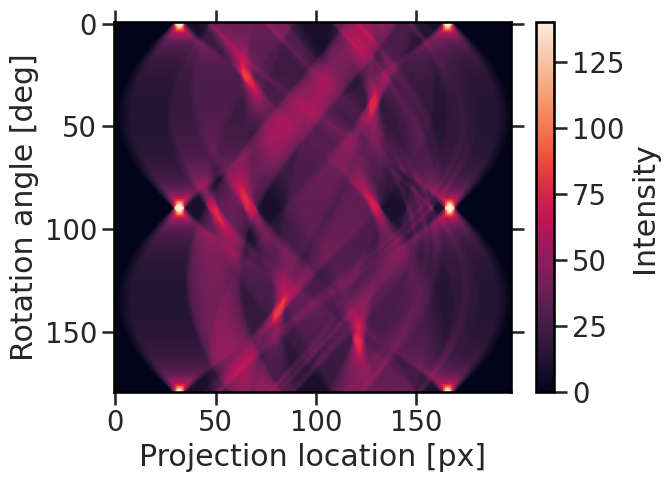

In [8]:
plt.imshow(proj.T)

plt.gca().set_aspect('auto')
plt.xlabel('Projection location [px]')
plt.ylabel('Rotation angle [deg]')
plt.colorbar(label='Intensity');

# Reconstruction Principle

<img src="img/iter1.gif" alt="projection" style="width:20%;float:left;margin-right:5%;margin-left:2.5%;margin-bottom:1em;margin-top:1em;" />
<img src="img/iter2.gif" alt="back-projection" style="width:20%;float:left;margin-right:5%;margin-bottom:1em;margin-top:1em;" />

<p style="clear: both; font-size: small; text-align: right; margin-top:1em;">images from <a href="https://tomograp.web.cern.ch/home_page/iter_tomo/iter_tomo/">CERN tomography website</a></p>

projection (measurement) $\implies$ back projection (reconstruction) 

(Require $ N_{meas} \gtrsim \pi\cdot\frac{\text{total diameter}}{\text{pixel size}}$)

<h2>Back Projection</h2>

Information is lost where along projection line $p$ the contributions of the integral came from.

$\implies$ simple approach for the back projection:
1. simply place constant integral value along $p$ for a given angle $\theta$.
2. integrate (sum up) for all $\theta$

<h2>Simple Example for Back Projection</h2>

<p style="clear: both; font-size: small; text-align: right; margin-top:1em;">images from <a href="https://www.desy.de/~garutti/LECTURES/BioMedical/Lecture7_ImageReconstruction.pdf">E. Garutti</a></p>

<img src="img/bp01.png" alt="simple example for back projection" style="width:60%;margin:auto;" />

<img src="img/bp02.png" alt="simple example for back projection" style="width:60%;margin:auto;" />

<img src="img/bp03.png" alt="simple example for back projection" style="width:60%;margin:auto;" />

<img src="img/bp04.png" alt="simple example for back projection" style="width:60%;margin:auto;" />

<img src="img/bp05.png" alt="simple example for back projection" style="width:60%;margin:auto;" />

<img src="img/bp06.png" alt="simple example for back projection" style="width:60%;margin:auto;" />

<img src="img/bp07.png" alt="simple example for back projection" style="width:60%;margin:auto;" />

<img src="img/bp08.png" alt="simple example for back projection" style="width:60%;margin:auto;" />

<img src="img/bp09.png" alt="simple example for back projection" style="width:60%;margin:auto;" />

<img src="img/bp10.png" alt="simple example for back projection" style="width:60%;margin:auto;" />

<img src="img/bp11.png" alt="simple example for back projection" style="width:60%;margin:auto;" />

<img src="img/bp12.png" alt="simple example for back projection" style="width:60%;margin:auto;" />

<h2>Fourier Slice Theorem</h2>

<div class="alert alert-block alert-success" style="text-align:center;">
Fourier Slice Theorem ("Projection-Slice Theorem" or "Central Slice Theorem"): <br /><br />
$$\mathcal{F}_\mathrm{1d}\bigl\{\mathcal{R}_{\theta'}(s) f\bigr\}=\mathcal{F}_\mathrm{2d}\bigl\{f(x,y)\bigr\}|_{\theta\mathop{=}\theta'}$$
</div>

i.e. the following two operations are equivalent:

1. project a 2D function $f(x,y)$ onto a line, 1D Fourier transform the result
2. 2D Fourier transform $f(x,y)$, extract a slice through the origin parallel to projection line
    
<img src="img/FST.png" alt="Fourier Slice Theorem" style="margin: auto; width:60%; margin-top:1em;" />

<p style="clear: both; font-size: small; text-align: right; margin-top:1em;">image from <a href="https://www.desy.de/~garutti/LECTURES/BioMedical/Lecture7_ImageReconstruction.pdf">E. Garutti</a></p>

<h2>Back Projection with FFT</h2>

Measured sinogram can be reconstructed via 
1. 1D FFT of each row (projection)
2. sum up around $\theta$, interpolation in 2D Fourier space
3. inverse 2D FFT

<img src="img/RadonFFT.png" alt="Inverse Radon transform via FFTs" style="width:80%;margin:auto;" />

<p style="clear: both; font-size: small; text-align: right; margin-top:1em;">image from <a href="https://commons.wikimedia.org/w/index.php?curid=72653784">P. Selinger</a></p>

<h2>Blurring & Filtering</h2>

<img src="img/stars.jpeg" alt="sampling artifact at origin" style="width:40%;margin:auto;" />

<p style="clear: both; font-size: small; text-align: right; margin-top:1em;">image from <a href="https://depts.washington.edu/imreslab/from%20old%20SITE/pet_intro/intro_src/section4.html">	
R. Badawi</a></p>

Unfortunately, back projection oversamples the origin in Fourier space $\leadsto$ high density at low frequencies!

The "tomographic reconstruction problem": effective blurring of reconstructed image, $f(x,y)\rightarrow f(x,y)* \frac{1}{\sqrt{x^2+y^2}}$

$\implies$ solution: "ramp" filter $F(v_x,v_y)\rightarrow \sqrt{v_x^2 + v_y^2}\cdot F(v_x,v_y)$ 

(the price to pay: amplification of high-frequency noise components)

<!--<h2>Filtered Back Projection</h2>

$$f(x,y) = \int\limits_0^{pi} d\theta \left[ \int\limits_{-\infty}^\infty d\omega |\omega| \right]$$
-->

<h2>Using Filtered Back Projection</h2>

Let's apply the back projection as an inverse Radon transform (implemented with a ramp filter):

In [9]:
AINV = lambda b: iradon(b, THETA, circle=False, filter_name='ramp', output_size=M).astype(float)

In [10]:
fbp = AINV(proj)

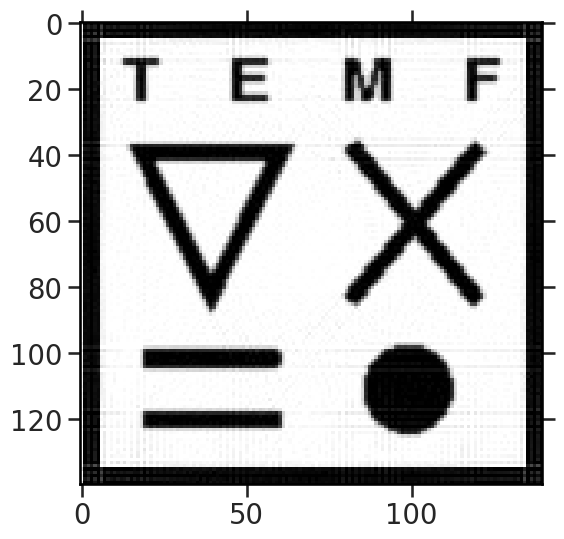

In [11]:
plt.figure(figsize=(12, 6))
plt.imshow(fbp, cmap='binary', vmin=0, vmax=1);

$\implies$ note the artifacts due to edges in the reconstructed image (high frequency!).

# Improved Reconstruction Principle

<img src="img/iter1.gif" alt="projection" style="width:20%;float:left;margin-right:5%;margin-left:2.5%;margin-bottom:1em;margin-top:1em;" />
<img src="img/iter2.gif" alt="back-projection" style="width:20%;float:left;margin-right:5%;margin-bottom:1em;margin-top:1em;" />
<img src="img/iter3.gif" alt="back-projection" style="width:20%;float:left;margin-right:5%;margin-bottom:1em;margin-top:1em;" />
<img src="img/iter4.gif" alt="back-projection" style="width:20%;float:left;margin-bottom:1em;margin-top:1em;" />

<p style="clear: both; font-size: small; text-align: right; margin-top:1em;">images from <a href="https://tomograp.web.cern.ch/home_page/iter_tomo/iter_tomo/">CERN tomography website</a></p>

projection (measurement) $\implies$ back projection (reconstruction) 

$\stackrel{\textcolor{red}{\text{improve}}}{\implies}$ re-projection (red) $\implies$ iteratively reduce discrepancy

# Reconstruction Algorithms

<div style="float:right;width:30%;">
<img src="https://upload.wikimedia.org/wikipedia/commons/5/54/Heart-direct-vs-iterative-reconstruction.png" alt="direct vs. iterative reconstruction" style="width:100%;" />
<p style="font-size: small; text-align: right; margin-top:1em;">image from <a href="https://commons.wikimedia.org/wiki/File:Heart-direct-vs-iterative-reconstruction.png">Biomed. NMR Forschungs GmbH</a></p>
<img src="img/art.png" alt="ART concept" style="width:100%;" />
<p style="font-size: small; text-align: right; margin-top:1em;">image from <a href="http://cds.cern.ch/record/1174559/files/CERN-PS-RF-Note-97-06.pdf">S. Hancock</a></p>
</div>

<b>Filtered Back Projection (FBP)</b> vs. <b>Iterative</b> Reconstruction

Iterative <b>algebraic reconstruction technique (ART)</b>: <br /> formulate reconstruction as algebraic problem $A\cdot x = b$

$\implies$ ART reconstructs $x$ iteratively <br /> (due to sparsity of $A$, sensitivity to perturbations / noise, <br />direction inversion $x=A^{-1}b$ is not a useful approach!)

First suggested in 1970 by R. Gordon, R. Bender, and G. Herman for tomography!

<h2>Comparison</h2>

| Filtered Back Projection | Algebraic Reconstruction Technique |
|:-:|:-:|
| FFT is fast | computationally expensive |
| low memory requirements | many coefficients, <br /> high memory requirements |
| requires many projections | more accurate, less artifacts |
| filtering is hard-coded<br /> into approach | can choose filtering |
| <p style="text-align:right;"><i> a-priori knowledge </i></p> <br />not possible | <p style="text-align:left;"><i> about distribution:</i></p> <br /> straight-forward |

<h2>Algebraic Reconstruction Technique</h2>

Describe the 2D density distribution under study by discrete bins (pixels), stacked into a column vector $x$.

A single projection by a ray at a given angle through the distribution is described by a row vector $a_i$. Applied to $x$, this single projection projection operation yields a pixel in a row of the sinogram, $b_i$.

The entire sinogram is collected by many projections $a_i$, which compose the (<b>huge</b> and <b>sparse</b>!) projection matrix $A_{ij}$:

$$ \sum\limits_j A_{ij} x_j = b_i $$

(each entry $x_j$ represents a discrete pixel of $x$, each $b_i$ represents a pixel in a row of the sinogram.)

Then, the algebraic reconstruction technique consists of the following iterative approximation scheme as a solution to the linear system of equations:

$$ x^{k+1} = x^k + \mu_k\frac{b_i - a_i\cdot x^k}{|a_i|^2} a_i^T $$

It converges better by introducing the (non-linear) constraint that all $x_j$ be positive, i.e. any pixel in $x$ should be set to zero if it turns negative after an iteration.

The relaxation factor $0<\mu_k\leq 1$ slows down convergence but improves the signal-to-noise ratio ($\mu_k=1$ $\rightarrow$ projection).

<h2>Effect of Noise</h2>

In the following, we will compare the FBP with the iterative ART approach on a noisy sinogram. 

We add $15\%$ of the maximum sinogram value as Gaussian normal distributed noise:

In [12]:
noise = np.random.normal(0, 0.15 * np.max(proj), size=proj.shape)

In [13]:
proj_noise = proj + noise

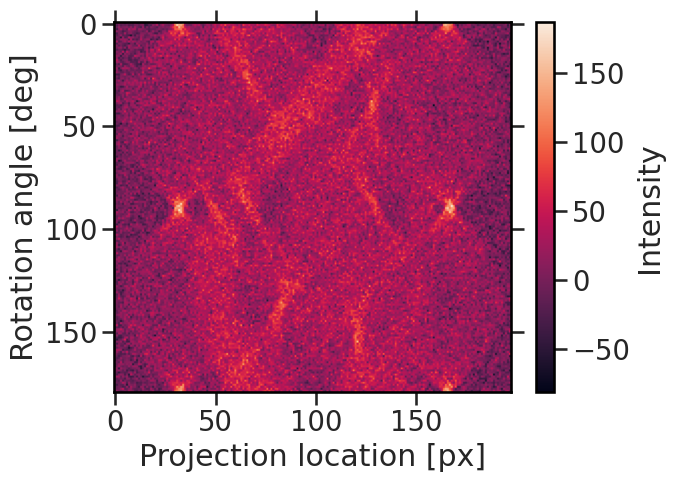

In [14]:
plt.imshow(proj_noise.T)
plt.gca().set_aspect('auto')
plt.xlabel('Projection location [px]')
plt.ylabel('Rotation angle [deg]')
plt.colorbar(label='Intensity');

<h2>Filtered Back Projection Results</h2>

In [15]:
fbp_noise = AINV(proj_noise)

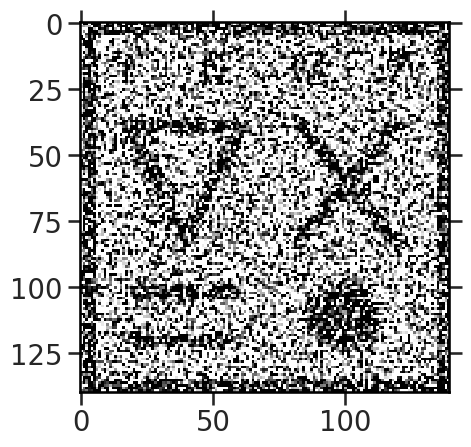

In [16]:
plt.imshow(fbp_noise, cmap='binary', vmin=0, vmax=1, interpolation='None');

<h2>Implement the Algebraic Reconstruction Technique</h2>

Besides the projection operator $A$, `A`, we need the adjoint $A^\mathrm{T}$, `AT`, for the ART implementation:

In [17]:
AT = lambda b: iradon(b, THETA, circle=False, filter_name=None, 
                      output_size=M).astype(float) * 2 * len(THETA) / np.pi

In [18]:
def ART(A, AT, b, x, mu=1, niter=10):
    # for all i: ||a_i||^2 = A^T ⋅ A
    ATA = AT(A(np.ones_like(x)))

    for i in tnrange(niter):
        x = x + np.divide(mu * AT(b - A(x)), ATA)

        # nonlinearity: constrain to >= 0 values
        x[x < 0] = 0

        plt.imshow(x, cmap='binary', vmin=0, vmax=1, interpolation='None')
        plt.title("%d / %d" % (i + 1, niter))
        plt.show()

    return x

# initialisation
x0 = np.zeros((M, M))
mu = 1
niter = 30

<h2>ART Results</h2>

  0%|          | 0/30 [00:00<?, ?it/s]

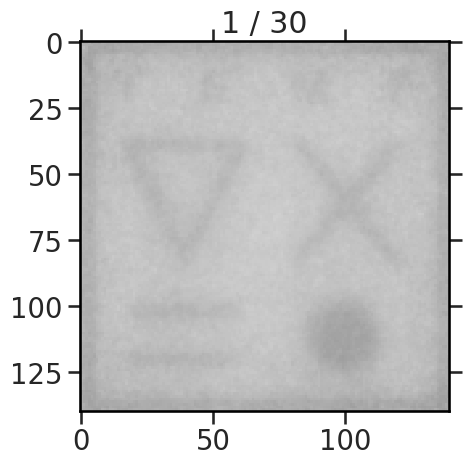

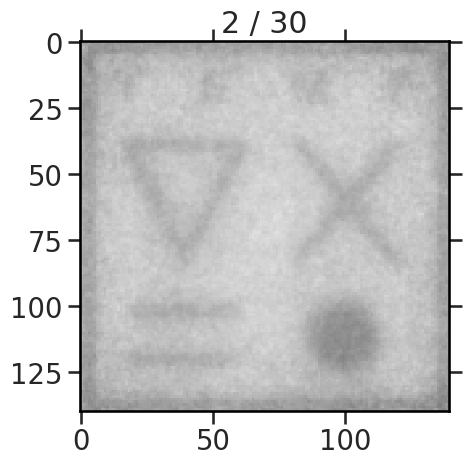

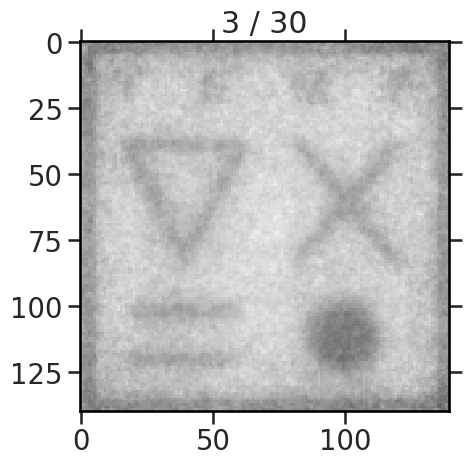

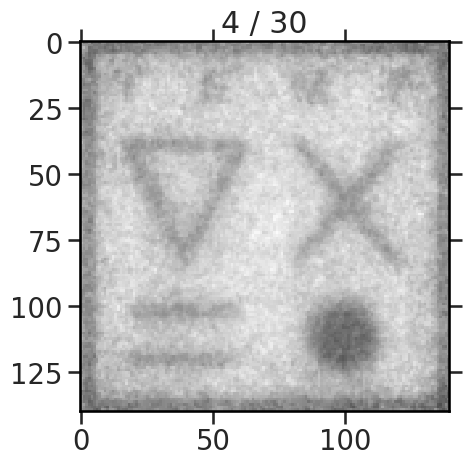

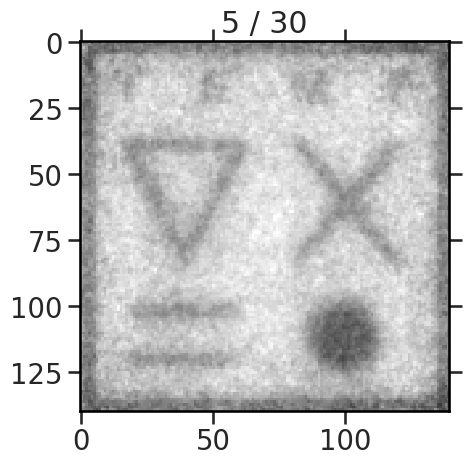

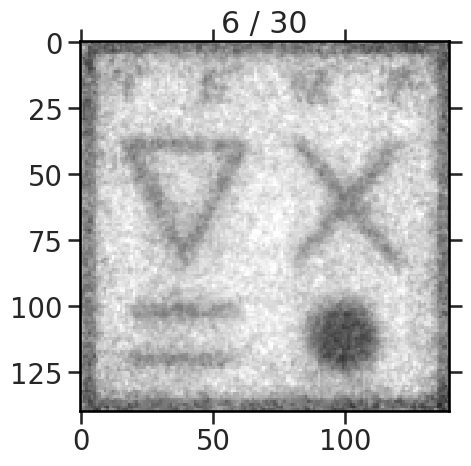

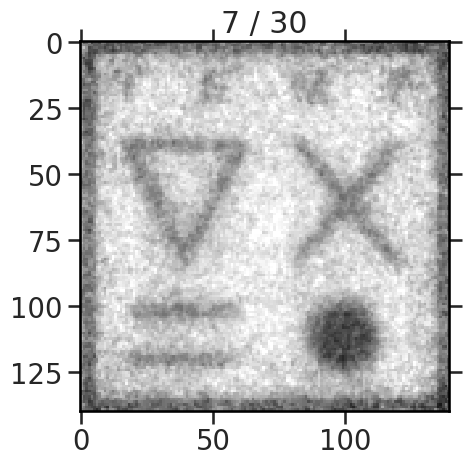

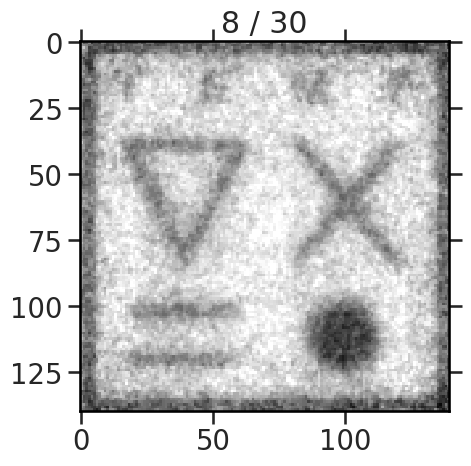

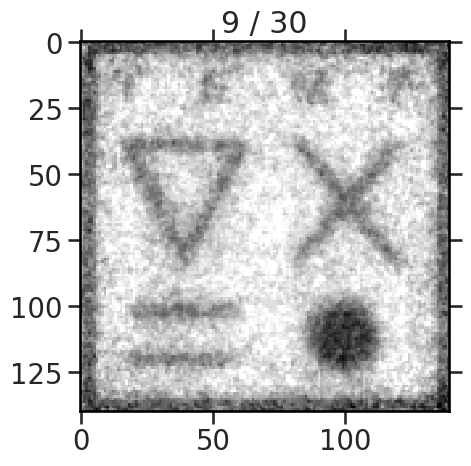

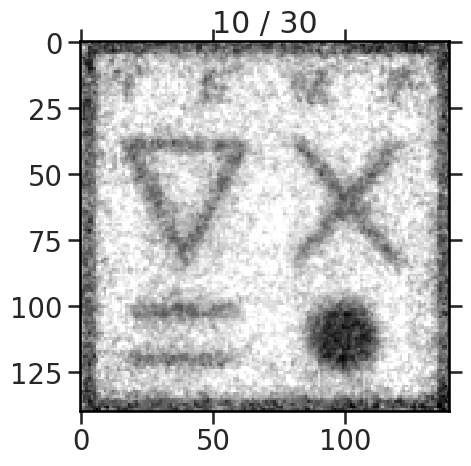

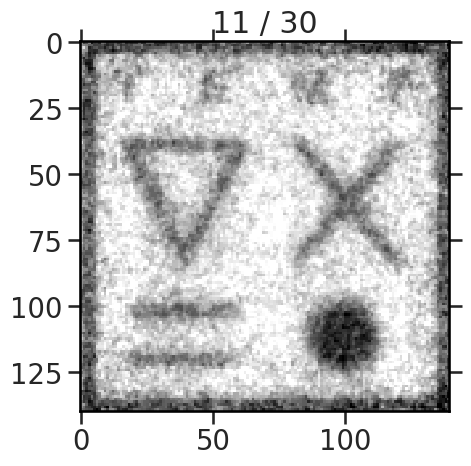

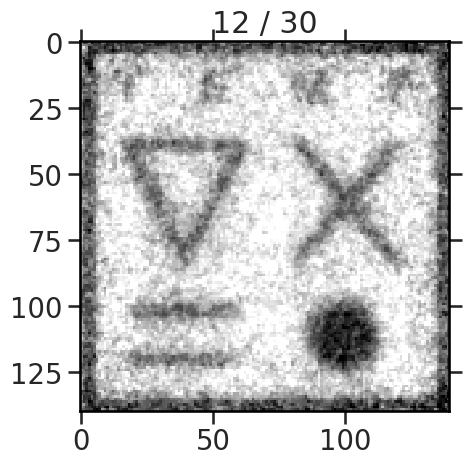

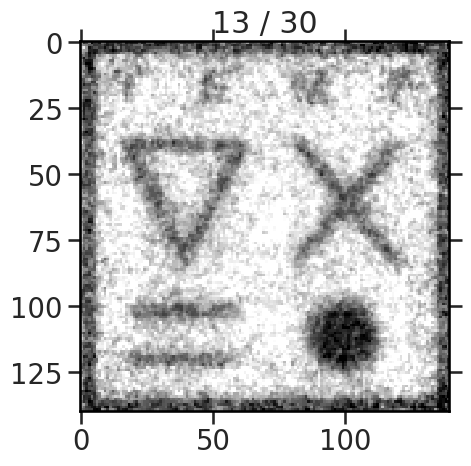

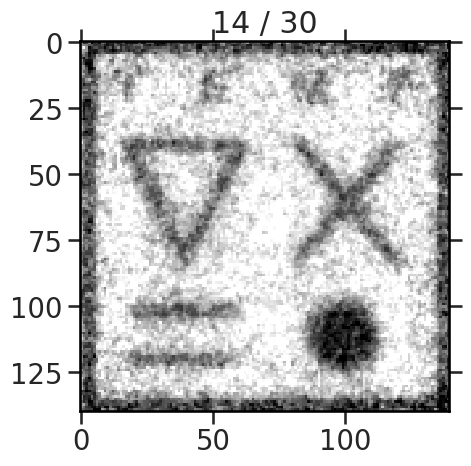

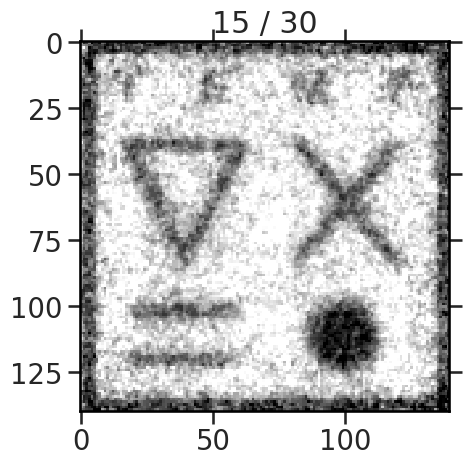

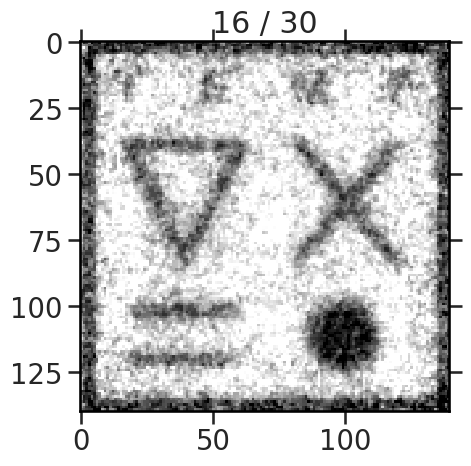

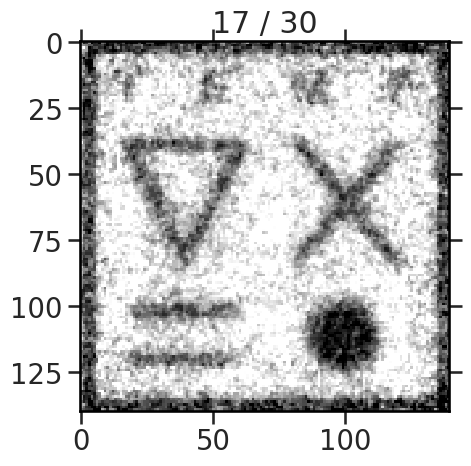

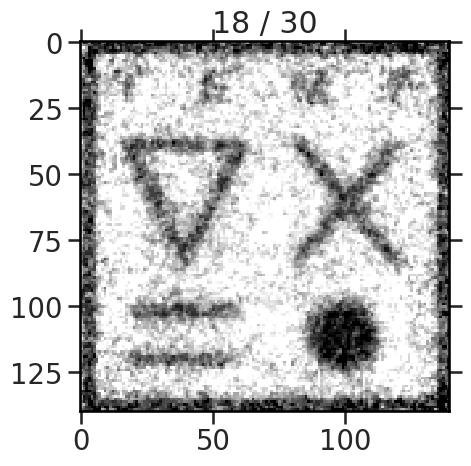

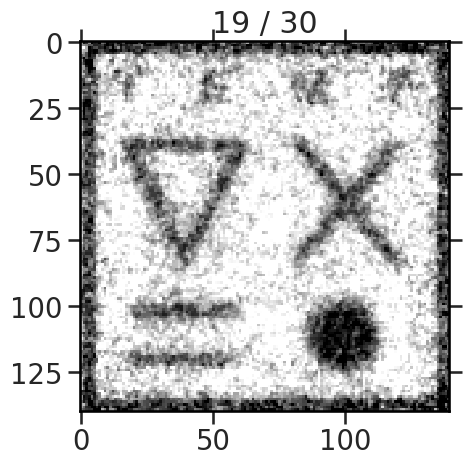

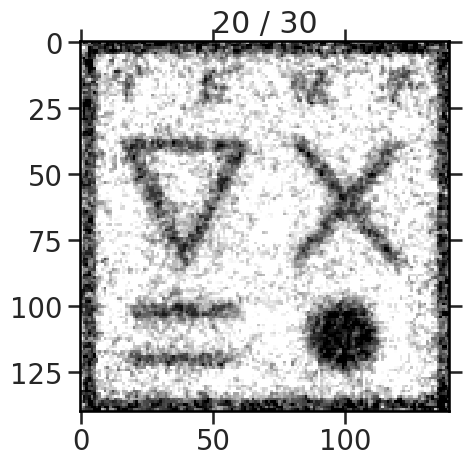

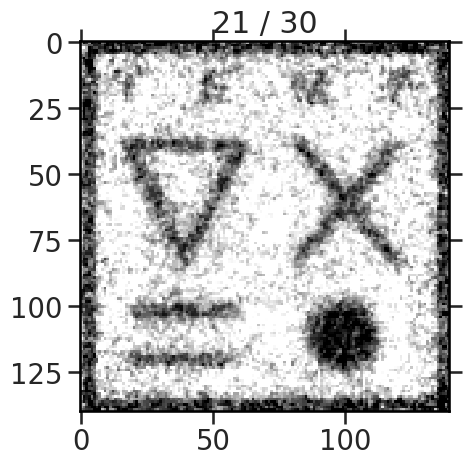

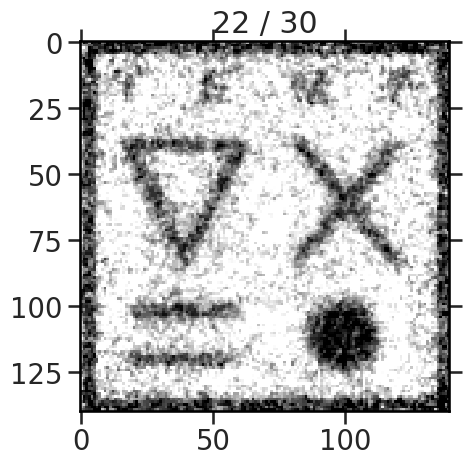

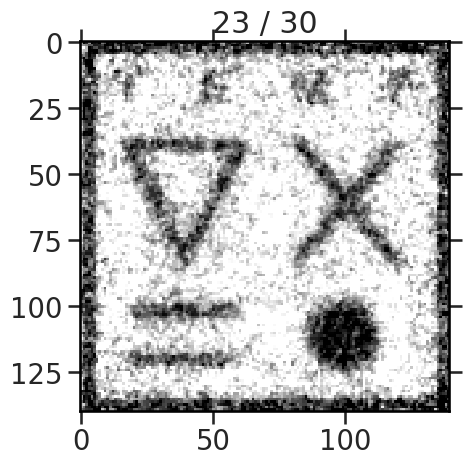

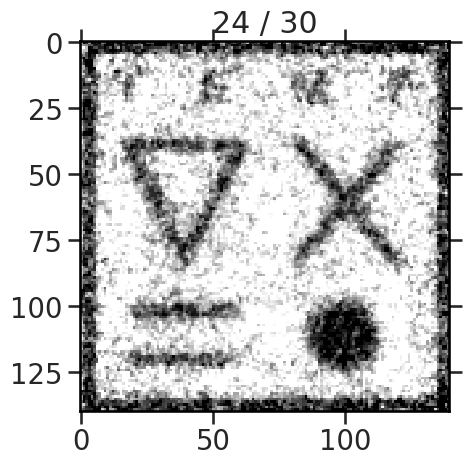

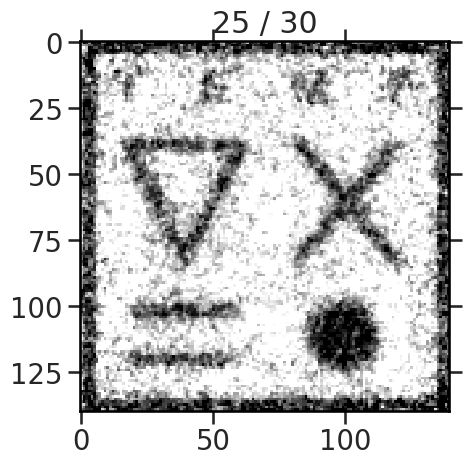

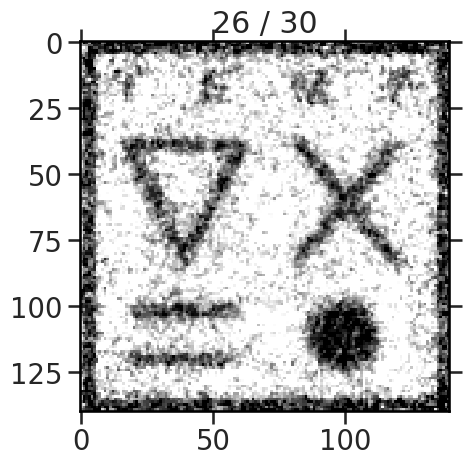

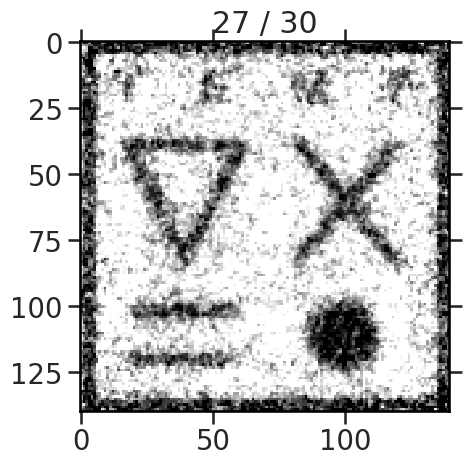

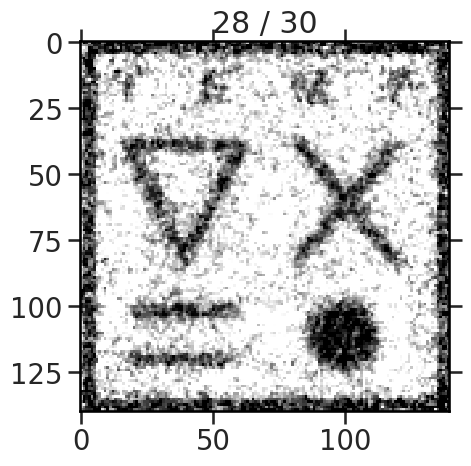

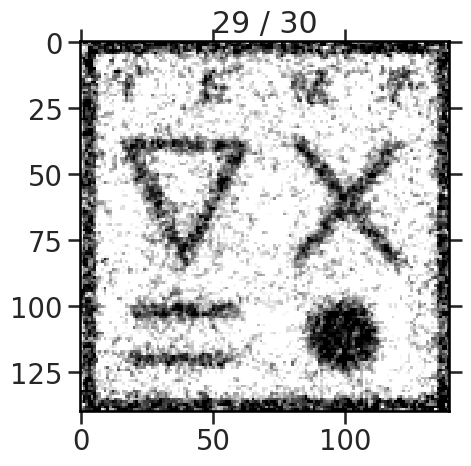

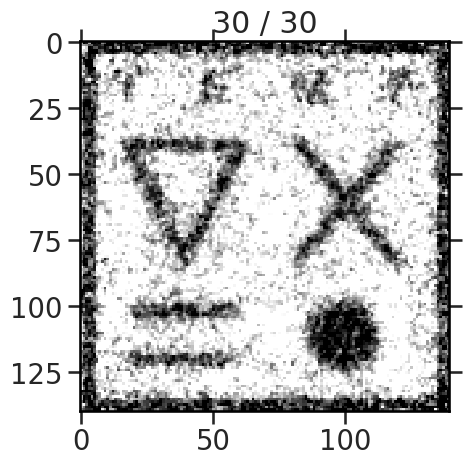

In [19]:
x_art = ART(A, AT, proj_noise, x0, mu, niter)

<h2>Comparison of the Results</h2>

ART typically outperforms FBP in terms of reconstruction quality:

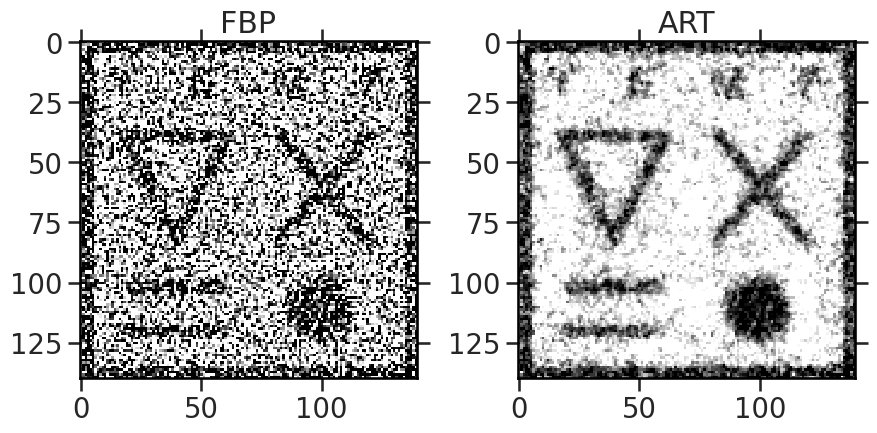

In [20]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.3)

plt.sca(ax[0])
plt.imshow(fbp_noise, cmap='binary', vmin=0, vmax=1, interpolation='None')
plt.title('FBP')

plt.sca(ax[1])
plt.imshow(x_art, cmap='binary', vmin=0, vmax=1, interpolation='None')
plt.title('ART');

$\implies$ the ART implementation is closely related to the Kaczmarz algorithm from numerical linear algebra.

<p style="color: #e6541a;">$\implies$ Can you run tomographic reconstruction for each of the following measured sinograms?</p>

```python
proj = np.load('data/sinogram1.npy')
proj = np.load('data/sinogram2.npy')
```

<div style="text-align: center; width:100%;">
    <h2>Part II: Phase-space Tomography</h2>
</div>

<h2>The Concept</h2>

- tomographically reconstruct longitudinal phase-space distribution!
- sinogram: consecutive measurements of bunch profiles over many turns
- problem: non-linear motion in longitudinal phase space

$\implies$ can modify ART: construct projection matrix $A$ from tracking! Then apply usual iterative mapping!

Introduced at [CERN in 1997 $\nearrow$](http://cds.cern.ch/record/1174559/files/CERN-PS-RF-Note-97-06.pdf) by Steven Hancock.

<img src="img/art_long.png" alt="tracking of particles for projection matrix" style="width:40%; margin:auto; margin-top:1em;" />

<p style="clear: both; font-size: small; text-align: right; margin-top:1em;">image from <a href="https://cdsweb.cern.ch/record/2750116/files/Longitudinal%20Phase%20Space%20Tomography%20Version%203.pdf">C. Grindheim & S. Albright</a></p>

The `longitudinal_tomography` package is developed at CERN: control room apps tomographically reconstruct the longitudinal phase-space distribution from bunch profile measurements!

In [21]:
import longitudinal_tomography.tomography.tomography as tmo
from longitudinal_tomography.tracking import particles, machine

import longitudinal_tomography.utils.tomo_input as tomoin
import longitudinal_tomography.utils.tomo_output as tomoout
from longitudinal_tomography.tracking import tracking

We work once more with the `PyHEADTAIL` library to generate the longitudinal macro-particle distribution.

Should it not be installed yet, please run this:

In [22]:
!pip install PyHEADTAIL==1.16.1

In [23]:
from PyHEADTAIL.particles.generators import RFBucketMatcher, ThermalDistribution
from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.16.1


<h2>Wall Current Monitor</h2>

In the vacuum tube, the <span style='color:#0C0;'>Beam</span> traverses a tube gap with <span style='color:red;'>resistors</span>, the <span style='color:#CC0;'>induced mirror current</span> builds up voltage:

$$ V_{gap} = R_{gap} \cdot I_{beam}$$

<img src="img/wcm.png" alt="wall current monitor principle" style="width:50%;margin:auto;margin-top:1em;" />

<p style="font-size: small; text-align: right;">image from <a href="https://uspas.fnal.gov/materials/09UNM/BeamCurrentMonitors.pdf">USPAS09</a> (W. Blokland, U. Raich)</p>

<h2>Beam Measurements</h2>

Consider a circulating bunch in a synchrotron or storage ring. Longitudinal bunch profiles can be recorded via wall current monitor with a high-bandwidth oscilloscope: store $V_{gap}(t)$ during the bunch passage time $t$.

## Physical beam parameters

During previous lectures we discussed reduced models for the longitudinal plane. We have 

- `voltage`: rf voltage
- `harmonic`: rf frequency divided by revolution frequency
- `circumference`: accelerator ring circumference
- `gamma`: Lorentz gamma of bunch
- `alpha_c`: momentum compaction of the ring

In [24]:
voltage = 24e3
harmonic = 7
circumference = 100 * 2 * np.pi

gamma = 3.1
beta = np.sqrt(1 - gamma**-2)

alpha_c = 0.027
eta = alpha_c - gamma**-2

We look at a circulating proton bunch in a CERN Proton Synchrotron like machine. A "full bunch length" of $B_L=180\,$ns translates to an rms bunch length in meters of $\sigma_z=B_L/4 \cdot \beta c$. As before, the following `PyHEADTAIL` `RFBucket` class captures most of the important quantities for computation.

In [25]:
rfb = RFBucket(circumference, gamma, m_p, e, [alpha_c], 0., [harmonic], [voltage], [np.pi])

sigma_z = 180e-9 * beta * c / 4. # in [m]

# A. The simulated measurement

## Initialisation of particles

A thermal distribution of $N$ particles is matched into the rf bucket.

In [26]:
N = 100000

In [27]:
np.random.seed(12345)

rfb_matcher = RFBucketMatcher(rfb, ThermalDistribution, sigma_z=sigma_z)
rfb_matcher.integrationmethod = 'cumtrapz'

z, dp, _, _ = rfb_matcher.generate(N)

*** Maximum RMS bunch length 14.146533693849051m.
... distance to target bunch length: -1.2642e+01
... distance to target bunch length: 9.8693e-01
... distance to target bunch length: 9.2123e-01
... distance to target bunch length: -6.1412e-01
... distance to target bunch length: 4.1253e-01
... distance to target bunch length: 1.2473e-01
... distance to target bunch length: -1.1252e-02
... distance to target bunch length: 8.1693e-04
... distance to target bunch length: 4.9433e-06
... distance to target bunch length: -1.0032e-05
--> Bunch length: 12.769481601844392
--> Emittance: 1.8021366059891775


In case `PyHEADTAIL` is not available, import the generated distribution directly (uncomment one of the following lines):

In [28]:
# z, dp = np.load('data/long-dist-80ns.npy') # short bunch
# z, dp = np.load('data/long-dist-180ns.npy') # long bunch

The distribution in longitudinal phase space $(z, \delta)$ looks as follows:

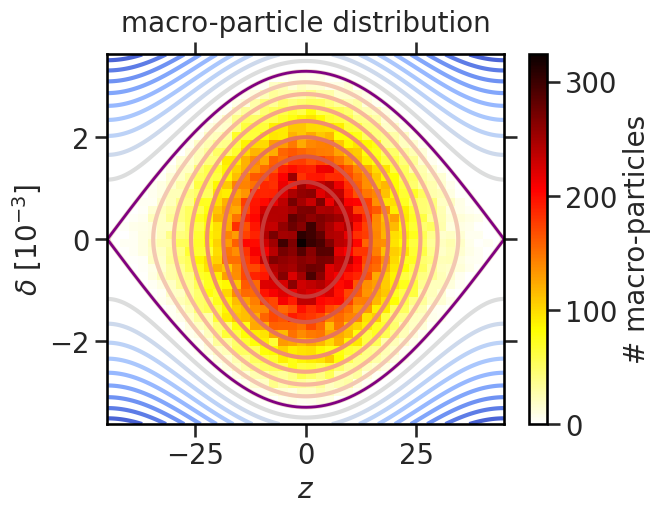

In [29]:
plot_mp(z, dp, rfb);

Let's have a look at the bunch profile as it would appear in a discrete measurement (e.g. via a wall current monitor):

In [30]:
nbins = 100
z_bins = np.linspace(*rfb.interval, num=nbins-1)

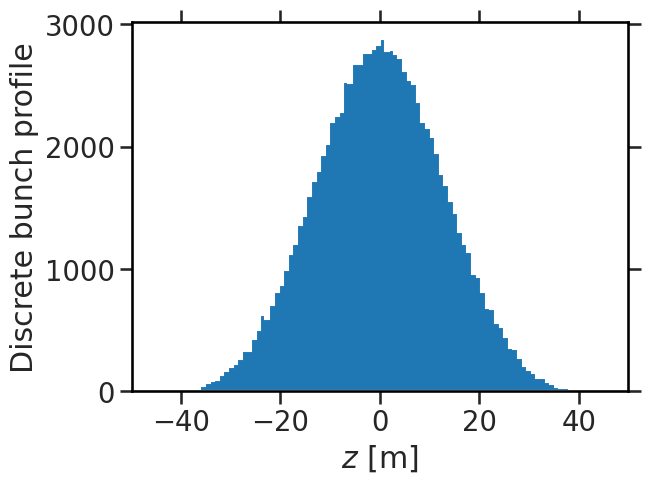

In [31]:
plt.hist(z, bins=z_bins, histtype='stepfilled')
plt.xlabel('$z$ [m]')
plt.ylabel('Discrete bunch profile');

A single bin of the profile measurement amounts to a time (in seconds) of 

In [32]:
dtbin = (z_bins[1] - z_bins[0]) / (beta * c)
dtbin

3.259992054798442e-09

The synchrotron period `T_s`, i.e. the time period of the longitudinal motion, amounts to the following number of turns:

In [33]:
T_s = int(1 / rfb.Q_s)
T_s

1124

## Deliberate mismatch

To provide some interesting dynamics for the tomographic reconstruction, let's mismatch the distribution in momentum. This will launch a <b>quadrupolar oscillation</b>, i.e. the bunch length and momentum spread will oscillate during the synchrotron period.

In [34]:
dp *= 0.3

As one can see, the distribution does not follow the iso-Hamiltonian lines (red) any longer but is slightly compressed along the momentum $\delta$ axis:

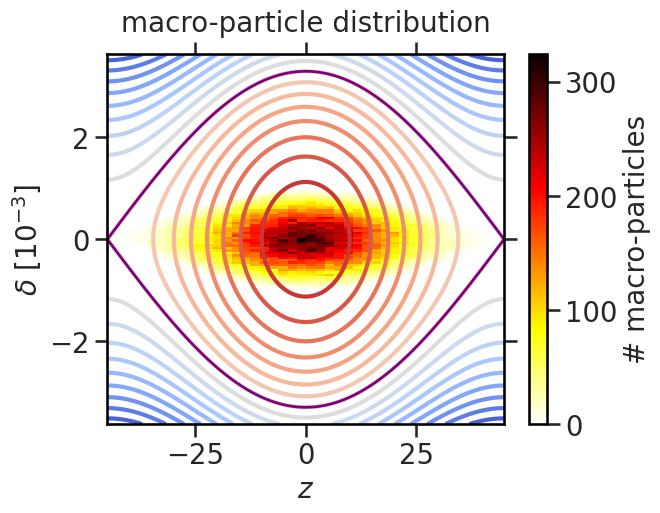

In [35]:
plot_mp(z, dp, rfb);

<h2>Particle Tracking</h2>

We model the synchrotron motion of the particles due to the rf cavities once more via a $2^\text{nd}$ order leap-frog integrator. The `track` function advances the particles by one turn:

In [36]:
def track(z, dp, rfb=rfb):
    # half drift
    z = z - eta * dp * circumference / 2
    # rf kick
    amplitude = rfb.charge * voltage / (beta * c * rfb.p0)
    phi = harmonic * (2 * np.pi * z / circumference) + rfb.phi_offset_list[0]
    dp += amplitude * np.sin(phi)
    # half drift
    z = z - eta * dp * circumference / 2
    return z, dp

Let's gather the data for the tomographic reconstruction by recording a bunch profile every few turns during one `T_s`:

In [37]:
record_every_nturns = 10

In [38]:
raw_data = [np.histogram(z, bins=z_bins)[0]]

for i in tnrange(1, T_s + 1):
    z, dp = track(z, dp)
    if not i % record_every_nturns:
        # the discrete WCM measurement:
        raw_data += [np.histogram(z, bins=z_bins)[0]]

  0%|          | 0/1124 [00:00<?, ?it/s]

The quadrupole oscillation is clearly visible:

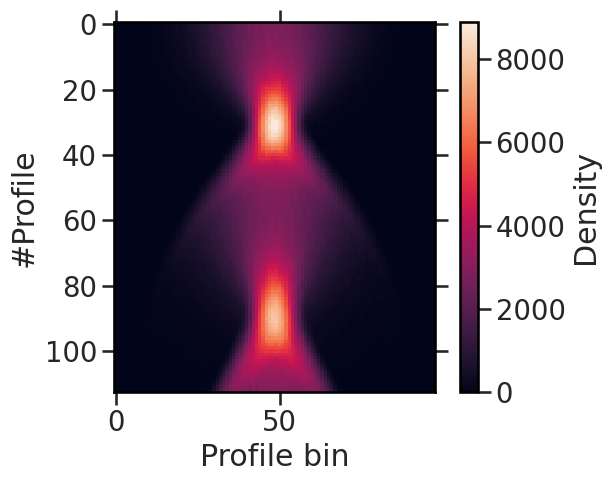

In [39]:
plt.imshow(raw_data)
plt.xlabel('Profile bin')
plt.ylabel('#Profile')
plt.colorbar(label='Density');

<p style="color: #e6541a;">$\implies$ Can you explain when the shortest bunch length (the bright spot with peak density) occurs? Why does one expect the shortest bunch length here, given the initial condition of the mismatched momentum distribution (with factor 0.3)?</p>

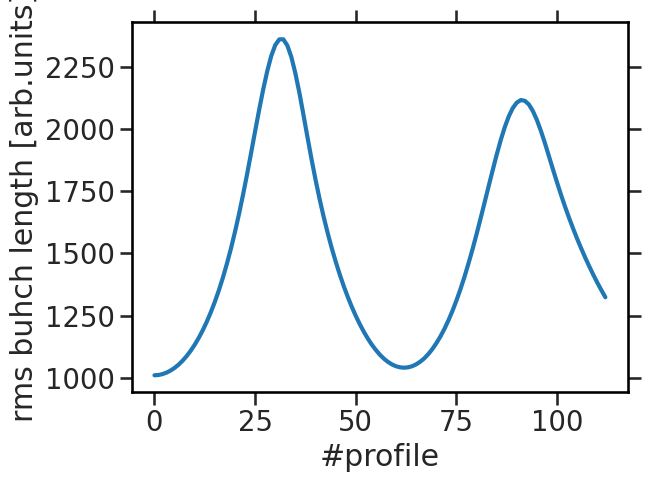

In [40]:
plt.plot(np.std(raw_data, axis=1))
plt.xlabel('#profile')
plt.ylabel('rms buhch length [arb.units]');

$\implies$ a $\gtrsim 100\%$ rms bunch length (quadrupole) oscillation takes place!

### Ready...

We have now gathered a simulated discrete WCM measurement in the `raw_data` array during one synchrotron period.

# B. The longitudinal tomographic reconstruction

## Preparations

The `longitudinal_tomography` package requires a certain input format for the machine parameters (voltage, frequency, etc):

In [41]:
frame_input_args = {
    'raw_data_path':    './',
    'framecount':       len(raw_data), # Number of frames in input data
    'skip_frames':      0, # Number of frames to ignore
    'framelength':      len(raw_data[0]), # Number of bins in each frame
    'dtbin':            dtbin, # Width (in s) of each frame bin
    'skip_bins_start':  0, # Number of frame bins before the lower profile bound to ignore
    'skip_bins_end':    0, # Number of frame bins after the upper profile bound to ignore
    'rebin':            1, #Number of frame bins to rebin into one profile bin
}

In [42]:
# computation of dipole B-field from beam rigidity Brho = p/e
Ekin = (gamma - 1) * m_p * c**2 / e
p0c = np.sqrt(Ekin**2 + 2*Ekin*m_p/e * c**2)
brho = p0c / c
brho / 70.08

0.13104352797152807

In [43]:
machine_args = {
    'output_dir':           '/tmp/', # Directory in which to write all output
    'dtbin':                dtbin, # Width (in s) of each frame bin
    'dturns':               record_every_nturns, # Number of machine turns between frames
    'synch_part_x':         frame_input_args['framelength']/2, # Time (in frame bins) 
                            # from the lower profile bound to the synchronous phase (if <0, 
                            # a fit is performed) in the "bunch reference" frame
    'demax':                -1e6, # noqa - Max energy (in eV) of reconstructed phase space (if >0)
    'filmstart':            0, # Number of the first profile at which to reconstruct
    'filmstop':             1, # Number of the last profile at which to reconstruct
    'filmstep':             1, # Step between reconstructions
    'niter':                50, # Number of iterations for each reconstruction
    'snpt':                 4, # Square root of the number of test particles to track per cell
    'full_pp_flag':         False, # Flag to extend the region in phase space of map elements (if =1)
    'beam_ref_frame':       0, # Reference frame for bunch parameters (synchronous phase, baseline, integral)
    'machine_ref_frame':    0, # Reference frame for machine parameters (RF voltages, B-field)
    'vrf1':                 voltage, # Peak RF voltage (in V) of principal RF system
    'vrf1dot':              0.0, # and its time derivative (in V/s)
    'vrf2':                 0.0, # Peak RF voltage (in V) of higher-harmonic RF system
    'vrf2dot':              0.0, # and its time derivative (in V/s)
    'h_num':                harmonic, # Harmonic number of principal RF system
    'h_ratio':              2.0, # Ratio of harmonics between RF systems
    'phi12':                0, # Phase difference (in radians of the principal harmonic) between RF systems
    'b0':                   brho / 70.08, # Dipole magnetic field (in T) -- up to 1.8T
    'bdot':                 0.0, # and its time derivative (in T/s) -- up to 10T/s
    'mean_orbit_rad':       circumference / (2 * np.pi), # Machine radius (in m)
    'bending_rad':          70.08, # Bending radius (in m)
    'trans_gamma':          alpha_c**-0.5, # Gamma transition
    'rest_energy':          m_p * c**2 / e, # Rest mass (in eV/c**2) of accelerated particle
    'charge':               1, # Charge state of accelerated particle
    'self_field_flag':      False, # Flag to include self-fields in the tracking (if =1)
    'g_coupling':           0.0, # Geometrical coupling coefficient
    'zwall_over_n':         0.0, # Reactive impedance (in Ohms per mode number) over a machine turn
    'pickup_sensitivity':   1, # Effective pick-up sensitivity (in digitizer units per instantaneous Amp)
    'nprofiles':            frame_input_args['framecount'],
    'nbins':                frame_input_args['framelength'],
    'min_dt':               0.0,
    'max_dt':               dtbin * frame_input_args['framelength'],
}

In [44]:
# initialising tomography
frames = tomoin.Frames(**frame_input_args)

mach = machine.Machine(**machine_args)

mach.values_at_turns()

The tomography package uses the waterfall plot of profiles <b>as measured sinogram input</b> then:

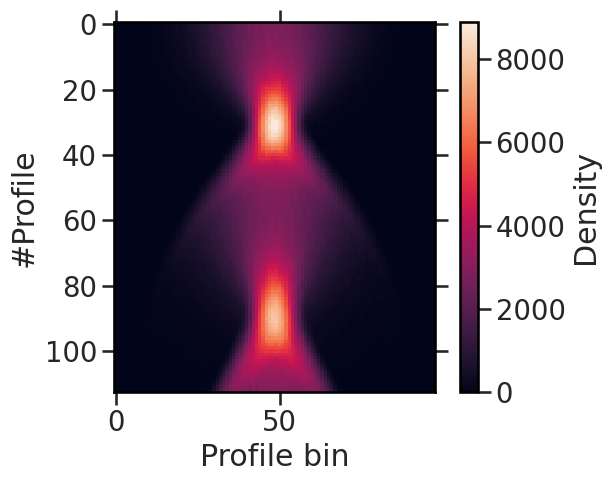

In [45]:
measured_waterfall = frames.to_waterfall(np.array(raw_data, dtype=float).flatten())

plt.imshow(measured_waterfall)
plt.xlabel('Profile bin')
plt.ylabel('#Profile')
plt.colorbar(label='Density');

<h2>Settings</h2>

Reconstruction will be carried out at the following profile index:

(choose `0` for the first profile, or `-2` for the last, or any number < `len(measured_waterfall) - 1`)

In [46]:
reconstr_idx = 0

Number of iterations of ART:

In [47]:
niterations = 50

<!--if profiles.machine.synch_part_x < 0:
    fit_info = dtreat.fit_synch_part_x(profiles)
    mach.load_fitted_synch_part_x_ftn(fit_info)-->

<h2>Projection Matrix</h2>

Establishing the map via tracking (nonlinear synchrotron motion), i.e. matrix $A$:

In [48]:
tracker = tracking.Tracking(mach)

phip, dEp = tracker.track(reconstr_idx)

In [49]:
# Converting from physical coordinates ([rad], [eV])
# to internal phase space coordinates.
if not tracker.self_field_flag:
    phip, dEp = particles.physical_to_coords(
        phip, dEp, mach, tracker.particles.xorigin,
        tracker.particles.dEbin)


In [50]:
phip, dEp = particles.ready_for_tomography(phip, dEp, mach.nbins)

profiles = tomoin.raw_data_to_profiles(
    measured_waterfall, mach, frames.rebin, frames.sampling_time)
profiles.calc_profilecharge()

waterfall = profiles.waterfall

In [51]:
# further preparations
nprofs = waterfall.shape[0]
nbins = waterfall.shape[1]
nparts = phip.shape[0]

flat_profs = waterfall.copy()
flat_profs = flat_profs.clip(0.0)

flat_profs /= np.sum(flat_profs, axis=1)[:, None]
flat_profs = np.ascontiguousarray(flat_profs.flatten()).astype(float)

waterfall /= np.sum(waterfall, axis=1)[:, None]

flat_points = phip.copy()
for i in range(nprofs):
    flat_points[:, i] += nbins * i

Starting the algebraic reconstruction technique (ART) algorithm:

In [52]:
# Initialising arrays with zeros
weight = np.zeros(nparts)
rec_wf = np.zeros(waterfall.shape)

In [53]:
# Initial estimation of weight factors using (flattened) measured profiles.
weight = tmo.libtomo.back_project(weight, flat_points, flat_profs,
                                  nparts, nprofs)
weight = weight.clip(0.0)

In [54]:
diff = []
for i in range(niterations):
    # Projection from phase space to time projections
    rec_wf = tmo.libtomo.project(rec_wf, flat_points, weight, nparts,
                                 nprofs, nbins)

    # Normalizing reconstructed waterfall
    rec_wf /= np.sum(rec_wf, axis=1)[:, None]

    # Finding difference between measured and reconstructed waterfall
    dwaterfall = waterfall - rec_wf

    # Setting to zero for next round
    rec_wf[:] = 0.0

    # Calculating discrepancy
    diff.append(np.sqrt(np.sum(dwaterfall**2) / (nbins * nprofs)))

    # Back projection using the difference between measured and recorded waterfall
    weight = tmo.libtomo.back_project(weight, flat_points, dwaterfall.flatten(),
                                      nparts, nprofs)
    # non-linearity of ART:
    weight = weight.clip(0.0)

    print(f'Iteration: {i:3d}, discrepancy: {diff[-1]:3e}')

Iteration:   0, discrepancy: 9.043262e-03
Iteration:   1, discrepancy: 7.403652e-03
Iteration:   2, discrepancy: 6.275827e-03
Iteration:   3, discrepancy: 5.433833e-03
Iteration:   4, discrepancy: 4.773068e-03
Iteration:   5, discrepancy: 4.241804e-03
Iteration:   6, discrepancy: 3.804729e-03
Iteration:   7, discrepancy: 3.437714e-03
Iteration:   8, discrepancy: 3.124893e-03
Iteration:   9, discrepancy: 2.854680e-03
Iteration:  10, discrepancy: 2.618902e-03
Iteration:  11, discrepancy: 2.411621e-03
Iteration:  12, discrepancy: 2.228095e-03
Iteration:  13, discrepancy: 2.064704e-03
Iteration:  14, discrepancy: 1.918603e-03
Iteration:  15, discrepancy: 1.787428e-03
Iteration:  16, discrepancy: 1.669183e-03
Iteration:  17, discrepancy: 1.562216e-03
Iteration:  18, discrepancy: 1.465202e-03
Iteration:  19, discrepancy: 1.377001e-03
Iteration:  20, discrepancy: 1.296639e-03
Iteration:  21, discrepancy: 1.223286e-03
Iteration:  22, discrepancy: 1.156163e-03
Iteration:  23, discrepancy: 1.094

In [55]:
# Finding last discrepancy...
rec_wf = tmo.libtomo.project(rec_wf, flat_points, weight, nparts, nprofs, nbins)
rec_wf /= np.sum(rec_wf, axis=1)[:, None]
dwaterfall = waterfall - rec_wf
diff.append(np.sqrt(np.sum(dwaterfall**2) / (nbins * nprofs)))

print(f'Iteration: {i + 1:3d}, discrepancy: {diff[-1]:3E}')

Iteration:  50, discrepancy: 4.192405E-04


Reconstruction finished, return the reconstructed phase-space distribution:

In [56]:
phasespace = tomoout.create_phase_space_image(
    phip, dEp, weight, nbins, reconstr_idx)

<!--# adjust plotting settings
import matplotlib
rcparams_before = matplotlib.rcParams.copy()
matplotlib.rc_file_defaults()
%matplotlib inline

# PLOT
tomoout.show(phasespace, diff, waterfall[reconstr_idx])

# return to usual settings
matplotlib.rcParams.update(rcparams_before)-->

<h2>Results from Tomography</h2>

The profile of the reconstructed distribution compared to the input profile:

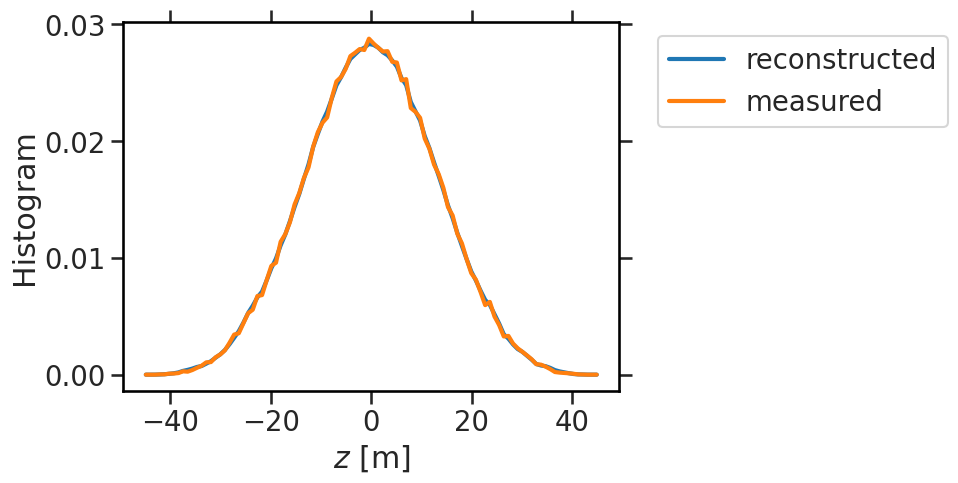

In [57]:
prof_rec = np.sum(phasespace, axis=1)
z_rec = (0.5 + np.arange(-len(prof_rec)/2, len(prof_rec)/2)) * (-dtbin * beta * c)

plt.plot(z_rec, prof_rec, label='reconstructed')
plt.plot(z_rec, waterfall[reconstr_idx], label='measured')

plt.xlabel('$z$ [m]')
plt.ylabel('Histogram')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

The reconstructed rms bunch length is: $\sigma_z = \sqrt{\cfrac{\sum_i p(z_i) \cdot (z_i - \langle z \rangle)^2}{\sum_i p(z_i)}}$

In [58]:
np.sqrt(np.trapz(prof_rec * z_rec**2, z_rec) / np.trapz(prof_rec, z_rec))

12.78047289439187

The original macro-particle distribution was generated with:

In [59]:
sigma_z

12.769476658495181

The momentum distribution of the reconstructed distribution:

In [60]:
Etot = Ekin + m_p/e * c**2 # in eV

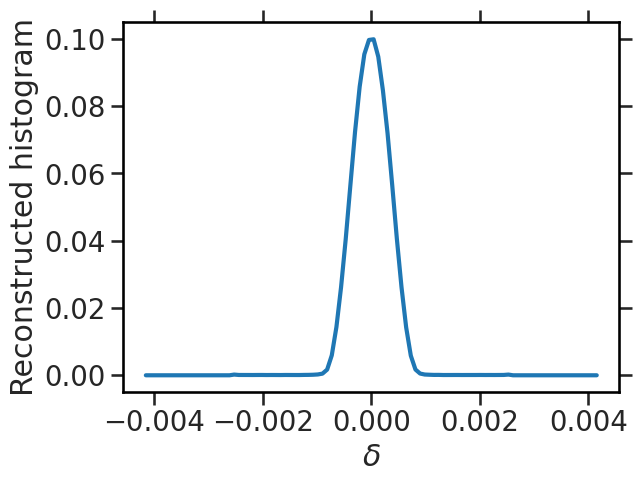

In [61]:
profdp_rec = np.sum(phasespace, axis=0)
dp_rec = (0.5 + np.arange(-len(profdp_rec)/2, len(profdp_rec)/2)) * (tracker.particles.dEbin / (Etot) * beta**2)

plt.plot(dp_rec, profdp_rec)
plt.xlabel('$\delta$')
plt.ylabel('Reconstructed histogram');

The reconstructed rms momentum deviation is: $\sigma_\delta = \sqrt{\cfrac{\sum_i p(\delta_i) \cdot (\delta_i - \langle \delta \rangle)^2}{\sum_i p(\delta_i)}}$

In [62]:
np.sqrt(np.trapz(profdp_rec * dp_rec**2, dp_rec) / np.trapz(profdp_rec, dp_rec))

0.0003310112038759302

Here is the full reconstructed phase-space distribution:

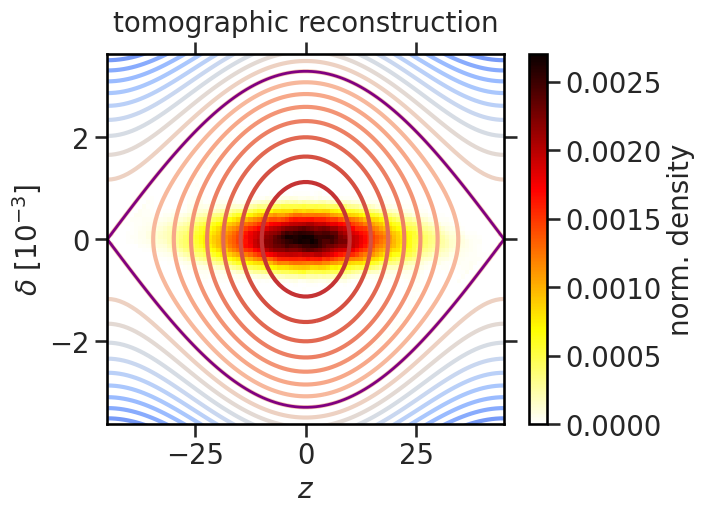

In [63]:
plot_tomo(phasespace, z_rec, dp_rec, rfb);

<p style="color: #e6541a;">Does this fit the initial macro-particle distribution? (Scroll up to section <b>A.</b> to compare!) <br /><br />Mind that this tomogram is <b>reconstructed purely from the spatial projections</b> (the simulated WCM measurements), the tomography algorithm has <b>no knowledge</b> of the macro-particles and their phase-space distribution!!<br /><br />
$\implies$ Re-run the tomographic reconstruction for the last profile (see settings part above, start from section <b>B.</b>)! Does it match the final macro-particle distribution?</p>

The final macro-particle phase-space distribution after the simulation:

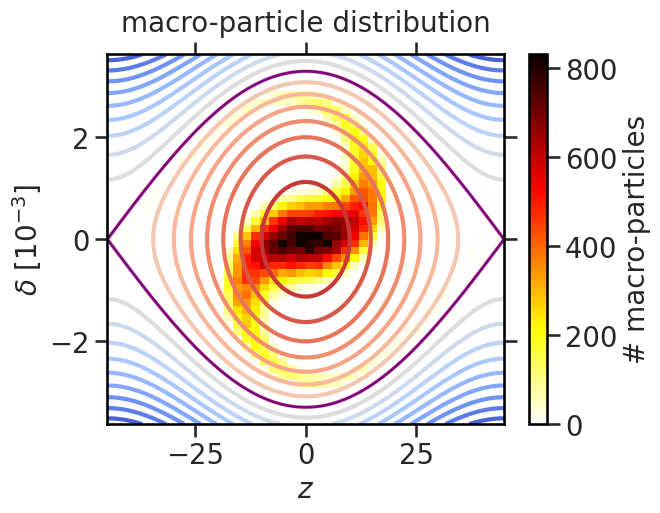

In [64]:
plot_mp(z, dp, rfb);

<p style="color: #e6541a;">$\implies$ Reconstruct some tomograms from actual measurements in the CERN PS Booster:</p>

1. [phase space filamentation](real-tomo-measurements1.ipynb)
2. ["string of pearls": digital rf phase feedback too strong](real-tomo-measurements2.ipynb)

The last example is also found on the [CERN tomography website $\nearrow$](https://tomograp.web.cern.ch/examples/examples/), where you find further nice tomography applications.

<h2>Summary</h2>

- Radon transform for line projections, construction of sinogram
- Reconstruction of $n$-dimensional distributions from $(n-1)$-dimensional projections
- Fourier Slice Theorem
- Filtered Back Projection
- Algebraic Reconstruction Technique
- Phase-space Tomography (concept: construction of projection matrix $A$ via non-linear tracking)

<h2>Original material used for this lecture</h2>

- [Y. Han's github repository on ART](https://github.com/hanyoseob/python-ART)

### A nice dedicated lecture on Iterative Algorithms:

- [Lecture on Algebraic Methods for Computed Tomography at TU of Denmark]( http://bme.elektro.dtu.dk/31545/notes/AlgebraicIterativeMethods.pdf)